In [1]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

In [80]:
import os
import sys
import json
import time
import pickle
import math

In [66]:
def create_directory(directory_path):
    """
    Function to create the directory locally
    :param directory_path: directory path
    :return:
    """
    if directory_path and not os.path.exists(directory_path):
        os.makedirs(directory_path)


In [2]:
model = VGG16(weights="imagenet", include_top=False)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
bloc

In [4]:
img_path = "../Data/flower_photos/daisy/100080576_f52e8ee070_n.jpg"

In [10]:
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

In [35]:
vgg16_feature = model.predict(img_data)

In [48]:
def extract_features(model, image_path):
    """
    :param model: vgg16 model
    :param image_path: image path for which to extract the features
    :return: feature vector of size 4096
    """
    img = image.load_img(image_path, target_size=(224, 224))
    imgData = image.img_to_array(img)
    imgData = np.expand_dims(imgData, axis=0)
    imgData = preprocess_input(imgData)
    feature = model.predict(imgData)
    feature = np.array(feature)
    return feature.flatten()

In [47]:
7 * 7 * 512

25088

In [14]:
img_data.shape

(1, 224, 224, 3)

In [37]:
vgg16_feature.shape, type(vgg16_feature)

((1, 7, 7, 512), numpy.ndarray)

In [42]:
vgg16_feature = np.array(vgg16_feature)

In [44]:
type(vgg16_feature), vgg16_feature.flatten().shape

(numpy.ndarray, (25088,))

In [73]:
base_path = "/Users/asingh/Documents/Learning/Projects/Image_Matching/"
data_path = os.path.join(base_path, "Data")
notebook_path = os.path.join(base_path, "Notebooks")
output_path = os.path.join(notebook_path, "Output")
image_path = os.path.join(data_path, "images")
feature_path = os.path.join(data_path, "features")
mapping_categories = {"bras": "panties", "panties": "bras"}
categories = ["bras", "panties"]
image_path_mappings = {"bras": os.path.join(image_path, "bras"), 
                      "panties": os.path.join(image_path, "panties")}

In [58]:
def feature_extractor(model, categories, image_path, feature_path):
    for category in categories:
        category_images_path = os.path.join(image_path, category)
        files = [os.path.join(category_images_path, file) for file in os.listdir(category_images_path)]

        result = {}
        for f in files:
            name = f.split('/')[-1].split(".")[0]
            try:
                result[name] = extract_features(model, f)
            except Exception as e:
                continue

        pickled_db_path = os.path.join(feature_path, model.name)
        if not os.path.exists(pickled_db_path):
            os.makedirs(pickled_db_path)
        with open(os.path.join(pickled_db_path, category + ".pck"), 'wb') as fp:
            pickle.dump(result, fp)

In [54]:
feature_extractor(model, categories, image_path, feature_path)

In [55]:
%%time
time.sleep(3)

CPU times: user 856 µs, sys: 1.68 ms, total: 2.53 ms
Wall time: 3 s


In [60]:
pickled_db_path = os.path.join(feature_path, model.name)
with open(os.path.join(pickled_db_path, "bras" + ".pck"), 'rb') as f:
    bras_features = pickle.load(f)

with open(os.path.join(pickled_db_path, "panties" + ".pck"), "rb") as f:
    panties_features = pickle.load(f)

In [62]:
all_features = {"bras": bras_features, "panties": panties_features}

In [63]:
from sklearn.cluster import KMeans

In [69]:
def findCosineSimilarity(feature1, feature2):
    """
    Fucntion to get the cos similarity between two vectors
    :param feature1:
    :param feature2:
    :return:
    """
    return np.dot(feature1, feature2) / (np.linalg.norm(feature1) * np.linalg.norm(feature2))

In [67]:
def calculate_similarity(features1, features2, category, output_path, top_matches_count=15):
    output_matches = {}
    for feature_name1, feature1 in features1.items():
        sku1, image_variation_name1 = feature_name1.split("_")
        if sku1 not in output_matches:
            output_matches[sku1] = {}
        output_matches[sku1][image_variation_name1] = []
        matches = []
        for feature_name2, feature2 in features2.items():
            sku2, image_variation_name2 = feature_name2.split("_")
            if feature_name1 != feature_name2:
                similarity = round(findCosineSimilarity(feature1, feature2), 4)
                matches.append((sku2, image_variation_name2, similarity))
        topmatches = sorted(matches, key=lambda x: x[2], reverse=True)[:top_matches_count]
        topmatches_formatted = [{"sku": sku2, "color_code": image_variation_name2,
                                 "similarity_score": str(score)} for sku2, image_variation_name2, score in topmatches]
        output_matches[sku1][image_variation_name1].extend(topmatches_formatted)
        
    try:
        with open(os.path.join(output_path, "{}.json".format(category)), "w") as output_file_object:
            output_file_object.write(json.dumps(output_matches))
    except Exception as e:
        print("Error in writing the image matches: {}".format(str(e)))
            

In [70]:
output_path_vgg16 = os.path.join(output_path, "vgg16")
create_directory(output_path_vgg16)

for c in categories:
    print("Computing for the category : {}".format(c))
    calculate_similarity(all_features[c], all_features[mapping_categories[c]], c, 
                         output_path_vgg16)

Computing for the category : bras
Computing for the category : panties


In [82]:
def generate_html(match_output_file_path, imgdir1, imgdir2, output_html_file_path, match_count=15, 
                  image_col_count=5):
    output_directory_path = output_html_file_path.rsplit("/", 1)[0]
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    if os.path.isfile(output_html_file_path):
        os.remove(output_html_file_path)
    try:
        with open(match_output_file_path) as ff:
            data = json.load(ff)
        with open(output_html_file_path, "w") as f:
            f.write('<html><body><table>')
            f.write('<style>table, th, td {border: 1px solid black;} </style>')
            htmlstr = '<tr> ' \
                      '<th> Variant Name </th> ' \
                      '<th align="center" colspan="{0}"> Image Matches </th>' \
                      '</tr>'.format(image_col_count)
            f.write(htmlstr)
            for sku, all_variants in data.items():
                for variant, similar_items in all_variants.items():
                    if "Default" in variant:
                        continue
                    base_imagename = sku + "_" + variant + ".jpg"
                    similar_items = similar_items[0:match_count]
                    htmlstr = ''
                    row_count = int(math.ceil(len(similar_items)/float(image_col_count)))
                    for n in range(row_count):
                        htmlstr += '<tr>'
                        if n == 0:
                            htmlstr += '<td rowspan="{0}" align="center" >' \
                                       '<img height="200" src="{1}/{2}"/>' \
                                       '<br/>' \
                                       '{3}' \
                                       '</td>' \
                                .format(row_count, imgdir1, base_imagename, "Variant:" + sku + "_" + variant)

                        for si in similar_items[image_col_count*n: image_col_count*n + image_col_count]:
                            matched_variant = si["sku"] + "_" + si["color_code"] + ".jpg"
                            htmlstr += '<td align="center" >' \
                                       '<img height="200" src="{0}/{1}"/>' \
                                       '<br/>' \
                                       '{2}' \
                                       '</td>'\
                                .format(imgdir2, matched_variant, si["sku"] + "_" + si["color_code"] + " : " + str(si["similarity_score"]))
                        htmlstr += '</tr>'
                    f.write(htmlstr)
            f.write('</table></body></html>')
    except Exception as e:
        print("HTML file creation failed with error: {}".format(str(e)))

In [83]:
for c in categories:
    print("Creating for the html file for category : {}".format(c))
    match_output_file_path = os.path.join(output_path_vgg16, "{}.json".format(c)) 
    output_html_file_path = os.path.join(output_path_vgg16, "{}.html".format(c))
    generate_html(match_output_file_path, image_path_mappings[c], image_path_mappings[mapping_categories[c]],
                  output_html_file_path, match_count=15, image_col_count=5)

Creating for the html file for category : bras
Creating for the html file for category : panties


In [77]:
base_image_url = "https://lanebryant.scene7.com/is/image/lanebryantProdATG/{sku}_{variant}?$medium$"


In [84]:
os.path.join(output_path_vgg16, "{}.html".format(c))


'/Users/asingh/Documents/Learning/Projects/Image_Matching/Notebooks/Output/vgg16/panties.html'

In [85]:
sample_image1 = "/Users/asingh/Documents/Learning/Projects/Image_Matching/Data/images/panties/244566_0000017962.jpg"
sample_image2 = "/Users/asingh/Documents/Learning/Projects/Image_Matching/Data/images/bras/244370_0000032447.jpg"



In [89]:
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
%matplotlib inline

The type of this input is <class 'numpy.ndarray'>
Shape: (1500, 1154, 3)


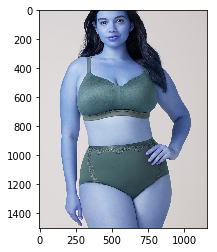

In [92]:
image = cv2.imread(sample_image1)
print("The type of this input is {}".format(type(image)))
print("Shape: {}".format(image.shape))
plt.imshow(image);

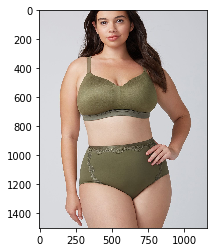

In [93]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

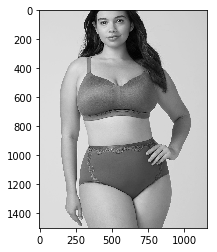

In [101]:
image = cv2.imread(sample_image1)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap="gray")

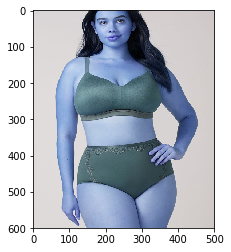

In [104]:
resized_image = cv2.resize(image, (500, 600))
plt.imshow(resized_image)

In [106]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [107]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [114]:
image = cv2.imread(sample_image1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
modified_image = cv2.resize(image, (600, 400), interpolation=cv2.INTER_AREA)
modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

In [113]:
modified_image.shape

(400, 600, 3)

In [115]:
modified_image.shape

(240000, 3)

In [116]:
clf = KMeans(n_clusters = 12)
labels = clf.fit_predict(modified_image)

In [117]:
import argparse

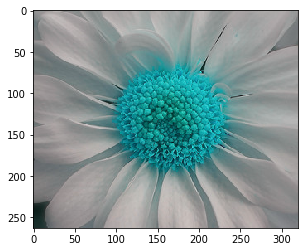

In [120]:
image = cv2.imread(img_path)
plt.imshow(image)

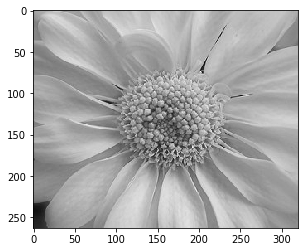

In [126]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")

'one'